In [1]:
%env MISFIT_PREP_CONFIG=processing.json 

input_data = {
    "data": [
        {
            "input": {
                "data_dir": "./misfit_data/data",
                "synt_dir": "./misfit_data/synth",
                "events": "./misfit_data/events_simulation_CI_CI_test_0_1507128030823",
                "event_id": "smi:webservices.ingv.it/fdsnws/event/1/query?eventId=1744261",
                "stations_dir": "./misfit_data/stations",
                "output_dir" : "./misfit_data/output",
                "network": [
                    "IV"
                ],
                "station": [
		    "ARRO"
                ]
            }
        }
    ]
}

env: MISFIT_PREP_CONFIG=processing.json


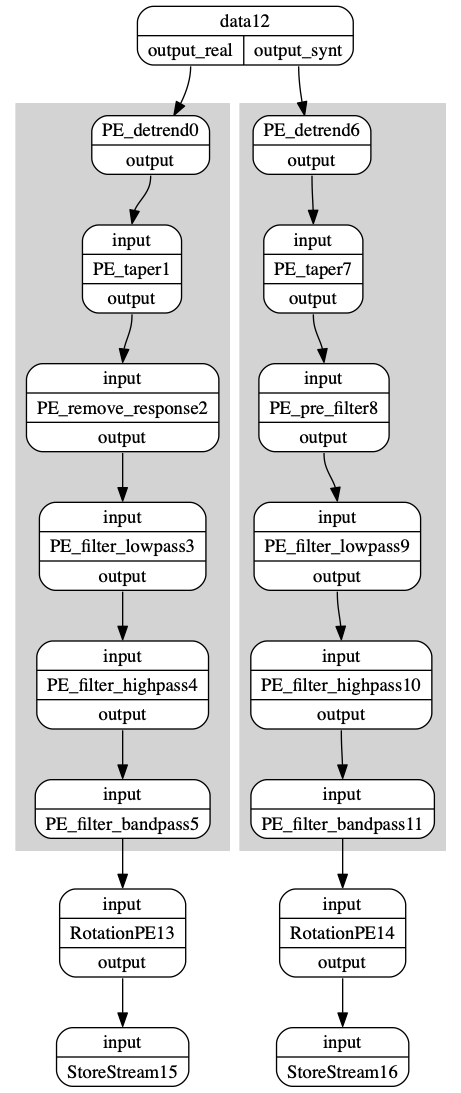

In [2]:
# Run:
# MISFIT_PREP_CONFIG="/Users/rosa/VERCE/dispy/dispel4py/test/seismo/misfit/processing.json" python -m dispel4py.new.processor simple dispel4py.test.seismo.misfit.create_misfit_prep -f /Users/rosa/VERCE/dispy/dispel4py/test/seismo/misfit/misfit_input.jsn
#
# Expects an environment variable MISFIT_PREP_CONFIG with the JSON file that specifies the preprocessing graph.

import json
import os
import sys

import preprocessing_functions as mf
from preprocessing_functions import get_event_time, get_synthetics, sync_cut, rotate_data
from dispel4py.provenance import *
from dispel4py.core import GenericPE
from dispel4py.seismo.seismo import SeismoSimpleFunctionPE, SeismoPE
from dispel4py.base import create_iterative_chain, ConsumerPE, IterativePE
from dispel4py.workflow_graph import WorkflowGraph
import dispel4py.new.simple_process as simple_process



class ReadDataPE(GenericPE):
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('output_real')
        self._add_output('output_synt')
        self.counter = 0

    def _process(self, inputs):
        params = inputs['input']
         
        stations = params['station']
        networks = params['network']
        data_dir = params['data_dir']
        synt_dir = params['synt_dir']
        event_file = params['events']
        event_id = params['event_id']
        stations_dir = params['stations_dir']
        output_dir = params['output_dir']
        fe = 'v'
        if self.output_units == 'velocity':
            fe = 'v'
        elif self.output_units == 'displacement':
            fe = 'd'
        elif self.output_units == 'acceleration':
            fe = 'a'
        else:
            self.log('Did not recognise output units: %s' % output_units)
        quakeml = event_file
        for i in range(len(stations)):
            station = stations[i]
            network = networks[i]
            data_file = os.path.join(data_dir, network + "." + station + ".." + '?H?.mseed')
            synt_file = os.path.join(synt_dir, network + "." + station + "." + '?X?.seed' + fe)
            ### in case we have the ascii synthetic traces, we have to comment the previous line, and uncomment the following one####### 
            #synt_file = os.path.join(synt_dir, network + "." + station + "." + '?X?.sem' + fe)
            sxml = os.path.join(stations_dir, network + "." + station + ".xml")
            real_stream, sta, event = mf.read_stream(data_file, sxml=sxml,
                                                  event_file=quakeml,
                                                  event_id=event_id)
            synt_stream = get_synthetics(synt_file, 
                                         get_event_time(quakeml, event_id), station, network)
            data, synt = sync_cut(real_stream, synt_stream)
            
            self.write(
                'output_real', [data, { 
                    'station' : sta, 
                    'event' : event, 
                    'stationxml' : sxml, 
                    'quakeml' : quakeml, 
                    'output_dir' : output_dir }
                ])
            self.write(
                'output_synt', [synt, {
                    'station' : sta, 
                    'event' : event, 
                    'stationxml' : sxml, 
                    'quakeml' : quakeml, 
                    'output_dir' : output_dir }
                ])

class RotationPE(IterativePE):
    def __init__(self, tag):
        IterativePE.__init__(self)
        self.tag = tag

    def _process(self, data):
        stream, metadata = data
        output_dir = metadata['output_dir']
        stations = metadata['station']
        event = metadata['event']
        stats = stream[0].stats
        filename = "%s.%s.%s.png" % (
            stats['network'], stats['station'], self.tag)
        #stream.plot(outfile=os.path.join(output_dir, filename))
        stream = rotate_data(stream, stations, event)
        filename = "rotate-%s.%s.%s.png" % (
            stats['network'], stats['station'], self.tag)
        #stream.plot(outfile=os.path.join(output_dir, filename))
        return (stream, metadata)


class StoreStream(ConsumerPE):
    def __init__(self, tag):
        ConsumerPE.__init__(self)
        self.tag = tag
        self._add_output('output')
        

    def _process(self, data):
        filelist = {}
        stream, metadata = data
        output_dir = metadata['output_dir']
        for i in range(len(stream)):
            stats = stream[i].stats
            filename = os.path.join(output_dir, "%s.%s.%s.%s" % (
                stats['network'], stats['station'], stats['channel'], self.tag))
            stream[i].write(filename, format='MSEED')
            #stream[i].write(filename, format='MSEED')
            filelist[stats['channel']] = filename
            self.write('output',stream,location=filename)


class MisfitPreprocessingFunctionPE(IterativePE):

    def __init__(self):
        IterativePE.__init__(self)

    def _process(self, data):
        stream, metadata = data
        result = self.compute_fn(stream, **self.params)
        return result, metadata


def create_processing_chain(proc):
    processes = []
    for p in proc:
        fn_name = p['type']
        params = p['parameters']
        fn = getattr(mf, fn_name)
        processes.append((fn, params))
    return create_iterative_chain(processes, FunctionPE_class=MisfitPreprocessingFunctionPE)

with open(os.environ['MISFIT_PREP_CONFIG']) as f:
    proc = json.load(f)


    
def buildWorkflow():
    real_preprocess = create_processing_chain(proc['data_processing'])
    synt_preprocess = create_processing_chain(proc['synthetics_processing'])
    print(real_preprocess)    
    graph = WorkflowGraph()
    read = ReadDataPE()
    read.name = 'data'
    read.output_units = proc['output_units']
    rotate_real = RotationPE('data')
    rotate_synt = RotationPE('synth')
    store_real = StoreStream('data')
    store_synt = StoreStream('synth')
    graph.connect(read, 'output_real', real_preprocess, 'input')
    graph.connect(read, 'output_synt', synt_preprocess, 'input')
    if proc['rotate_to_ZRT']:
        graph.connect(real_preprocess, 'output', rotate_real, 'input')
        graph.connect(synt_preprocess, 'output', rotate_synt, 'input')
        graph.connect(rotate_real, 'output', store_real, 'input')
        graph.connect(rotate_synt, 'output', store_synt, 'input')
    else:
        graph.connect(real_preprocess, 'output', store_real, 'input')
        graph.connect(synt_preprocess, 'output', store_synt, 'input')
    
    return graph
    

graph=buildWorkflow() 

from dispel4py.visualisation import display
display(graph)

In [3]:
#!python -m dispel4py.new.processor simple create_misfit_prep.py -f misfit_input.jsn

In [4]:
def runExampleWorkflow(graph):
                                                     
    print(input_data)                   
    graph.flatten()
    #Launch in simple process
    result = simple_process.process_and_return(graph, input_data)
    print("\n RESULT: "+str(result))

runExampleWorkflow(graph)

{'data': [{'input': {'data_dir': './misfit_data/data', 'synt_dir': './misfit_data/synth', 'events': './misfit_data/events_simulation_CI_CI_test_0_1507128030823', 'event_id': 'smi:webservices.ingv.it/fdsnws/event/1/query?eventId=1744261', 'stations_dir': './misfit_data/stations', 'output_dir': './misfit_data/output', 'network': ['IV'], 'station': ['ARRO']}}]}


/anaconda3/lib/python3.7/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):
/anaconda3/lib/python3.7/site-packages/obspy/io/mseed/core.py:772: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


13.5697 41.7143
13.5697 41.7143
SimplePE: Processed 1 iteration.

 RESULT: {'StoreStream15': {'output': [<obspy.core.stream.Stream object at 0x10bf31ac8>, <obspy.core.stream.Stream object at 0x10bf31ac8>, <obspy.core.stream.Stream object at 0x10bf31ac8>]}, 'StoreStream16': {'output': [<obspy.core.stream.Stream object at 0x1c1f1f5c88>, <obspy.core.stream.Stream object at 0x1c1f1f5c88>, <obspy.core.stream.Stream object at 0x1c1f1f5c88>]}}


In [5]:
#Store via service
#ProvenanceType.REPOS_URL='http://127.0.0.1:8082/workflowexecutions/insert'
#ProvenanceType.PROV_EXPORT_URL='http://127.0.0.1:8082/data/'

#ProvenanceType.REPOS_URL='http://snf-3480.ok-kno.grnetcloud.net/prov/workflowexecutions/insert'
#ProvenanceType.PROV_EXPORT_URL='http://snf-3480.ok-kno.grnetcloud.net/prov/data/'

#http://snf-3480.ok-kno.grnetcloud.net:8082/swagger/
ProvenanceType.REPOS_URL='http://ec2-18-197-219-251.eu-central-1.compute.amazonaws.com/workflowexecutions/insert'
ProvenanceType.PROV_EXPORT_URL='http://ec2-18-197-219-251.eu-central-1.compute.amazonaws.com/workflowexecutions/'

#Store to local path
ProvenanceType.PROV_PATH='./prov-files/'

#Size of the provenance bulk before sent to storage or sensor
ProvenanceType.BULK_SIZE=1

#ProvenancePE.REPOS_URL='http://climate4impact.eu/prov/workflow/insert'

In [6]:
prov_config =  {
                    'provone:User': "aspinuso", 
                    's-prov:description' : "provdemo demokritos",
                    's-prov:workflowName': "demo_epos",
                    's-prov:workflowType': "seis:preprocess",
                    's-prov:workflowId'  : "workflow process",
                    's-prov:save-mode'   : 'service'         ,
                    # defines the Provenance Types and Provenance Clusters for the Workflow Components
                    's-prov:componentsType' : 
                                       {'PE_taper': {'s-prov:type':(SeismoSimpleFunctionPE,),
                                                     's-prov:prov-cluster':'seis:Processor'},
                                        'StoreStream':    {'s-prov:prov-cluster':'seis:DataHandler',
                                                           's-prov:type':(SeismoPE,)},
                                        },
                    's-prov:sel-rules': None
                } 

Change grouping implementation 
PE_detrend Original base class: (<class 'dispel4py.base.IterativePE'>,)
(<class 'dispel4py.provenance.ProvenanceType'>,)
 New type: (<class 'dispel4py.provenance.ProvenanceType'>, <class '__main__.MisfitPreprocessingFunctionPE'>)
PE_detrend Original base class: (<class 'dispel4py.base.IterativePE'>,)
(<class 'dispel4py.provenance.ProvenanceType'>,)
 New type: (<class 'dispel4py.provenance.ProvenanceType'>, <class '__main__.MisfitPreprocessingFunctionPE'>)
PE_filter_bandpass Original base class: (<class 'dispel4py.base.IterativePE'>,)
(<class 'dispel4py.provenance.ProvenanceType'>,)
 New type: (<class 'dispel4py.provenance.ProvenanceType'>, <class '__main__.MisfitPreprocessingFunctionPE'>)
PE_filter_bandpass Original base class: (<class 'dispel4py.base.IterativePE'>,)
(<class 'dispel4py.provenance.ProvenanceType'>,)
 New type: (<class 'dispel4py.provenance.ProvenanceType'>, <class '__main__.MisfitPreprocessingFunctionPE'>)
PE_filter_highpass Original base

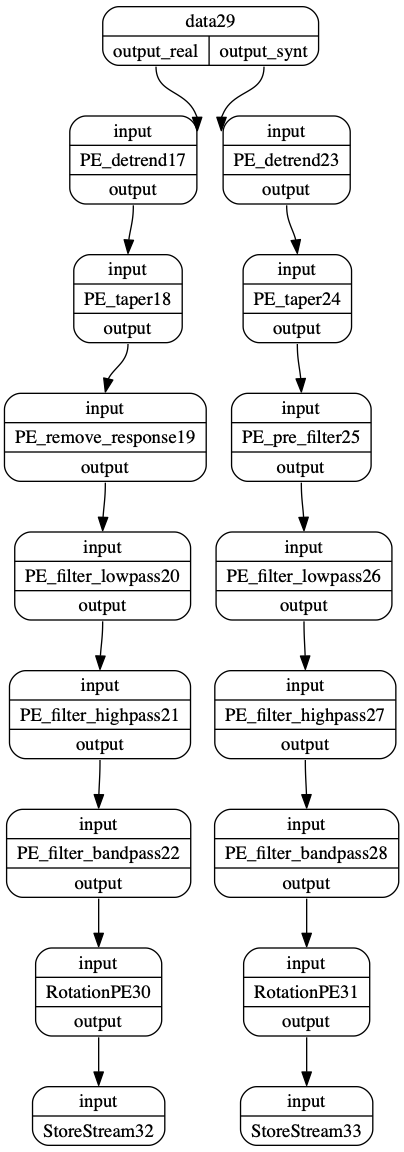

In [7]:
def createGraphWithProv():
    
    graph = buildWorkflow()
    # Ranomdly generated unique identifier for the current run
    rid='JUP_PREPOC_'+getUniqueId()

    
    # Finally, provenance enhanced graph is prepared:
    

     
    #Initialise provenance storage to service:
    configure_prov_run(graph, 
                     provImpClass=(ProvenanceType,),
                     username=prov_config['provone:User'],
                     runId=rid,
                     description=prov_config['s-prov:description'],
                     workflowName=prov_config['s-prov:workflowName'],
                     workflowType=prov_config['s-prov:workflowType'],
                     workflowId=prov_config['s-prov:workflowId'],
                     save_mode=prov_config['s-prov:save-mode'],
                     componentsType=prov_config['s-prov:componentsType'],
                     sel_rules=prov_config['s-prov:sel-rules']
                      
                    )
    
    return graph,rid


graph,rid=createGraphWithProv()

display(graph)

In [8]:
runExampleWorkflow(graph)


{'data': [{'input': {'data_dir': './misfit_data/data', 'synt_dir': './misfit_data/synth', 'events': './misfit_data/events_simulation_CI_CI_test_0_1507128030823', 'event_id': 'smi:webservices.ingv.it/fdsnws/event/1/query?eventId=1744261', 'stations_dir': './misfit_data/stations', 'output_dir': './misfit_data/output', 'network': ['IV'], 'station': ['ARRO']}}]}
{'input': {'data_dir': './misfit_data/data', 'synt_dir': './misfit_data/synth', 'events': './misfit_data/events_simulation_CI_CI_test_0_1507128030823', 'event_id': 'smi:webservices.ingv.it/fdsnws/event/1/query?eventId=1744261', 'stations_dir': './misfit_data/stations', 'output_dir': './misfit_data/output', 'network': ['IV'], 'station': ['ARRO']}}
data29: BUILDING INITIAL DERIVATION
{'input': {'_d4p': [<obspy.core.stream.Stream object at 0x1c1fd23668>, {'station': <obspy.core.inventory.inventory.Inventory object at 0x1c1fd5c6d8>, 'event': Event(resource_id=ResourceIdentifier(id="smi:webservices.ingv.it/fdsnws/event/1/query?eventId=1

/anaconda3/lib/python3.7/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):
/anaconda3/lib/python3.7/site-packages/obspy/io/mseed/core.py:772: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)



         network: IV
         station: ARRO
        location: 
         channel: HXZ
       starttime: 2013-02-16T21:16:09.240000Z
         endtime: 2013-02-16T21:17:09.240000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 6001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 12, 'encoding': 'FLOAT32', 'byteorder': '>', 'record_length': 4096, 'filesize': 49152})
      processing: ['ObsPy 1.1.0: decimate(factor=2::no_filter=True::strict_length=False)', "ObsPy 1.1.0: interpolate(args=()::method='cubic'::npts=5999::sampling_rate=100.0::starttime=UTCDateTime(2013, 2, 16, 21, 16, 9, 240000)::time_shift=0.0)", "ObsPy 1.1.0: detrend(options={}::type='linear')", "ObsPy 1.1.0: taper(max_length=None::max_percentage=0.05::side='both'::type='hann')", "ObsPy 1.1.0: filter(options={'freq': 2.0, 'corners': 3, 'zerophase': False}::type='lowpass')", "ObsPy 1.1.0: filter(options={'freq': 0.1, 'corners': 3, 'zerophase

PE_filter_bandpass22: Postprocess: (200, 'OK', b'{"inserts": ["PE_filter_bandpass22_write_orfeus-as-46685-93f5283c-3920-11e9-8a45-4a0005199ad0"], "success": true}')
RotationPE30: Postprocess: (200, 'OK', b'{"inserts": ["RotationPE30_write_orfeus-as-46685-93f570a8-3920-11e9-8a45-4a0005199ad0"], "success": true}')
StoreStream32: Postprocess: (200, 'OK', b'{"inserts": ["StoreStream32_write_orfeus-as-46685-93feb9a6-3920-11e9-8a45-4a0005199ad0"], "success": true}')
PE_detrend23: Postprocess: (200, 'OK', b'{"inserts": ["PE_detrend23_write_orfeus-as-46685-93fff2b2-3920-11e9-8a45-4a0005199ad0"], "success": true}')
PE_taper24: Postprocess: (200, 'OK', b'{"inserts": ["PE_taper24_write_orfeus-as-46685-94016b56-3920-11e9-8a45-4a0005199ad0"], "success": true}')
PE_pre_filter25: Postprocess: (200, 'OK', b'{"inserts": ["PE_pre_filter25_write_orfeus-as-46685-94026ea2-3920-11e9-8a45-4a0005199ad0"], "success": true}')
PE_filter_lowpass26: Postprocess: (200, 'OK', b'{"inserts": ["PE_filter_lowpass26_writ

In [9]:
import xml.etree.ElementTree as ET

print("Extract Trace for run: "+rid)
expurl = urlparse(ProvenanceType.PROV_EXPORT_URL)
connection = httplib.client.HTTPConnection(expurl.netloc)
url="http://"+expurl.netloc+expurl.path+rid+"/export?level=100&format=xml"

print(url)
connection.request(
                "GET", url)
response = connection.getresponse()
  
print("progress: " + str((response.status, response.reason)))
prov1 = ET.fromstring(response.read())
print('PROV TO EMBED:')
print(str(prov1))

Extract Trace for run: JUP_PREPOC_orfeus-as-46685-93199b28-3920-11e9-8a45-4a0005199ad0
http://ec2-18-197-219-251.eu-central-1.compute.amazonaws.com/workflowexecutions/JUP_PREPOC_orfeus-as-46685-93199b28-3920-11e9-8a45-4a0005199ad0/export?level=100&format=xml
progress: (200, 'OK')
PROV TO EMBED:
<Element '{http://www.w3.org/ns/prov#}document' at 0x1c1fc86868>


In [10]:
import prov
from IPython.display import Image
import io
from prov.model import ProvDocument, ProvBundle, ProvException, first, Literal
from prov.dot import prov_to_dot

def provURLToPNG(xml,format):
     
    xml_doc = io.BytesIO(urllib.request.urlopen(xml).read())
    doc=ProvDocument.deserialize(xml_doc,format="xml")
    dot = prov_to_dot(doc)
    
    if format=="png":
        dot.write_png('PROV.png')
        return 'PROV.png' 
    if format=="svg":
        dot.write_svg('PROV.svg')
        return 'PROV.svg'
    
    


png_content=provURLToPNG(url,"png")

Image(png_content)
